In [2]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv

  TAREA: Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. 

  Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

  Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo. 

C:\Users\dasum\AppData\Local\Temp\ipykernel_14776\3178118661.py:54: RuntimeWarning: overflow encountered in scalar subtract
  distancias = [np.sqrt((x - cx)**2 + (y - cy)**2) for (cx, cy, _) in circles[0, :]]
C:\Users\dasum\AppData\Local\Temp\ipykernel_14776\3178118661.py:54: RuntimeWarning: overflow encountered in scalar add
  distancias = [np.sqrt((x - cx)**2 + (y - cy)**2) for (cx, cy, _) in circles[0, :]]


Moneda de referencia seleccionada en (136, 346)
Moneda de referencia seleccionada en (426, 288)


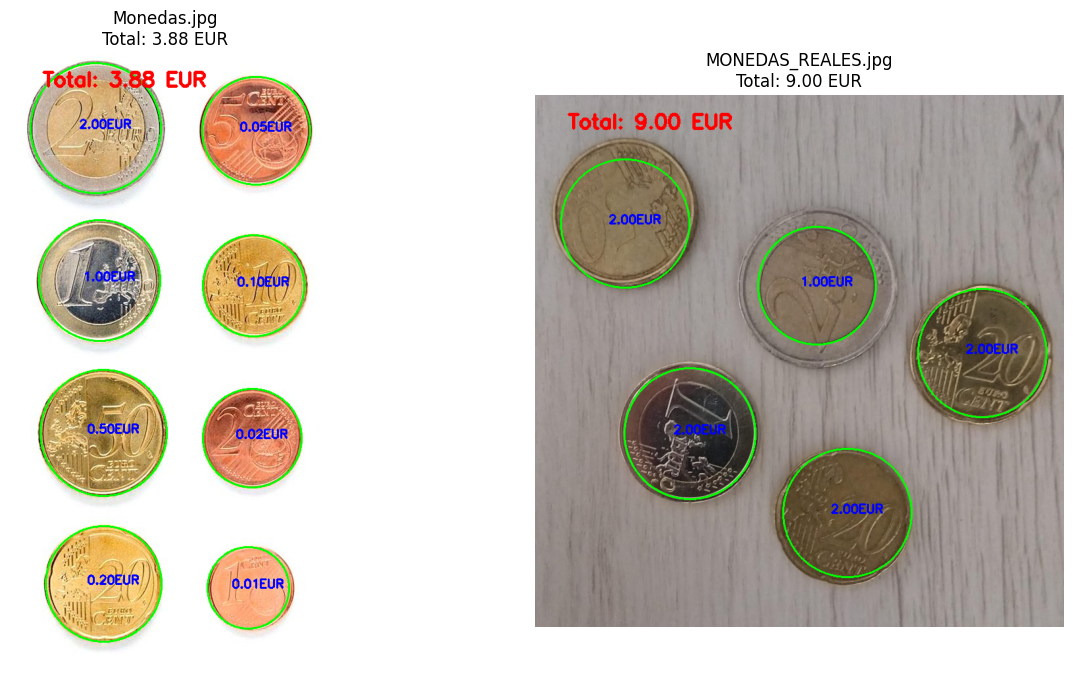

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def redimensionar_imagen(img, ancho_max=800):
    alto, ancho = img.shape[:2]
    if ancho > ancho_max:
        escala = ancho_max / ancho
        nuevo_ancho = int(ancho * escala)
        nuevo_alto = int(alto * escala)
        img_redim = cv2.resize(img, (nuevo_ancho, nuevo_alto))
        return img_redim
    else:
        return img

#  --- 1. Cargar imágenes ---
img = cv2.imread("Monedas.jpg")

img1 = cv2.imread("MONEDAS_REALES.jpg") 
img1 = redimensionar_imagen(img1, ancho_max=800) # nueva imagen
if img is None or img1 is None:
    raise IOError("No se pudieron cargar las imágenes.")

# --- Función para procesar cada imagen ---
def procesar_monedas(img):
    img_display = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 5)

    # Detectar monedas
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
        param1=100, param2=45, minRadius=25, maxRadius=100
    )

    if circles is None:
        raise ValueError("No se detectaron monedas en la imagen.")

    circles = np.uint16(np.around(circles))

    # Dibujar todas las monedas detectadas
    for (x, y, r) in circles[0, :]:
        cv2.circle(img_display, (x, y), r, (0, 255, 0), 2)
        cv2.circle(img_display, (x, y), 2, (0, 0, 255), 3)

    # Selección de la moneda de referencia
    ref_diametro_mm = 23.25
    escala_mm_px = None
    ref_pos = None

    def seleccionar_moneda(event, x, y, flags, param):
        nonlocal escala_mm_px, ref_pos, img_display
        if event == cv2.EVENT_LBUTTONDOWN:
            distancias = [np.sqrt((x - cx)**2 + (y - cy)**2) for (cx, cy, _) in circles[0, :]]
            idx = np.argmin(distancias)
            (cx, cy, r) = circles[0][idx]
            ref_pos = (cx, cy)
            diametro_ref_px = 2 * r
            escala_mm_px = ref_diametro_mm / diametro_ref_px
            print(f"Moneda de referencia seleccionada en ({cx}, {cy})")
            # resaltar la referencia
            img_display[:] = img.copy()
            for (x0, y0, r0) in circles[0, :]:
                cv2.circle(img_display, (x0, y0), r0, (0, 255, 0), 2)
            cv2.circle(img_display, (cx, cy), r, (0, 0, 255), 3)

    cv2.namedWindow("Selecciona moneda de referencia")
    cv2.setMouseCallback("Selecciona moneda de referencia", seleccionar_moneda)
    while escala_mm_px is None:
        cv2.imshow("Selecciona moneda de referencia", img_display)
        if cv2.waitKey(1) & 0xFF == 27:
            break
    cv2.destroyAllWindows()

    if escala_mm_px is None:
        raise ValueError("No se seleccionó ninguna moneda de referencia.")

    # Valores de monedas
    monedas_info = {
        16.25: 0.01,
        18.75: 0.02,
        19.75: 0.10,
        21.25: 0.05,
        22.25: 0.20,
        23.25: 1.00,
        24.25: 0.50,
        25.75: 2.00
    }

    total = 0
    resultado = img.copy()

    for (x, y, r) in circles[0, :]:
        diametro_mm = 2 * r * escala_mm_px
        diametro_real = min(monedas_info.keys(), key=lambda d: abs(d - diametro_mm))
        valor = monedas_info[diametro_real]
        total += valor
        cv2.circle(resultado, (x, y), r, (0, 255, 0), 2)
        cv2.putText(resultado, f"{valor:.2f}EUR", (x - 25, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.putText(resultado, f"Total: {total:.2f} EUR", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    return resultado, total

# --- Procesar ambas imágenes ---
resultado1, total1 = procesar_monedas(img)
resultado2, total2 = procesar_monedas(img1)

# --- Mostrar ambas imágenes con Matplotlib ---
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(resultado1, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Monedas.jpg\nTotal: {total1:.2f} EUR")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(resultado2, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"MONEDAS_REALES.jpg\nTotal: {total2:.2f} EUR")

plt.show()


TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.
